### This notebook demonstrates two methods for connecting to Postgres.

The first is [iPython-sql](https://pypi.python.org/pypi/ipython-sql) a "magic" for Jupyter Notebook (what this document is written in).

The second is [Psycopg](http://initd.org/psycopg/), which is the fundamental Postgres connector for Python.

In [1]:
%load_ext sql

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [2]:
%sql postgresql:///decibel

u'Connected: None@decibel'

In [3]:
%sql SELECT now()

1 rows affected.


now
2016-11-12 01:09:03.282118+00:00


In [4]:
import psycopg2
db = psycopg2.connect('')

In [5]:
db

<connection object at 0x1087ef8a0; dsn: '', closed: 0>

In [6]:
%sql SET application_name = 'ipython-sql'

Done.


[]

In [7]:
db.cursor().execute("SET application_name = 'psycopg2'")
db.commit()

In [8]:
db.cursor().execute('CREATE TEMP TABLE i(i int)')

In [9]:
%sql SELECT pid,datname,usename,application_name,state_change,state,query FROM pg_stat_activity

4 rows affected.


pid,datname,usename,application_name,state_change,state,query
46931,decibel,decibel,psql,2016-11-12 01:08:56.806783+00:00,idle,SELECT pg_catalog.pg_backend_pid() AS backend_pid
46976,decibel,decibel,ipython-sql,2016-11-12 01:10:54.847484+00:00,active,"SELECT pid,datname,usename,application_name,state_change,state,query FROM pg_stat_activity"
47259,decibel,decibel,psycopg2,2016-11-12 01:10:53.172094+00:00,idle in transaction,CREATE TEMP TABLE i(i int)
47620,catalog,postgres,,None,None,


Because the sql magic uses SQLalchemy under the hood, it can end up in a transaction, which means you might get stale data. If that happens, you want to issue either a `ROLLBACK;` or `COMMIT;`.

In [10]:
%%sql
ROLLBACK;
SELECT pid,datname,usename,application_name,state_change,state,query FROM pg_stat_activity;

Done.
3 rows affected.


pid,datname,usename,application_name,state_change,state,query
46931,decibel,decibel,psql,2016-11-12 01:08:56.806783+00:00,idle,SELECT pg_catalog.pg_backend_pid() AS backend_pid
46976,decibel,decibel,,2016-11-12 01:11:17.722069+00:00,active,"SELECT pid,datname,usename,application_name,state_change,state,query FROM pg_stat_activity;"
47259,decibel,decibel,psycopg2,2016-11-12 01:10:53.172094+00:00,idle in transaction,CREATE TEMP TABLE i(i int)


`%sql` does use it's own, separate connection though, so it can't see anything that's not yet committed.

In [11]:
%sql SELECT * FROM pg_tables WHERE tableowner='decibel'

0 rows affected.


schemaname,tablename,tableowner,tablespace,hasindexes,hasrules,hastriggers,rowsecurity


In [12]:
db.commit()

In [13]:
%sql SELECT * FROM pg_tables WHERE tableowner='decibel'

1 rows affected.


schemaname,tablename,tableowner,tablespace,hasindexes,hasrules,hastriggers,rowsecurity
pg_temp_4,i,decibel,None,False,False,False,False


In [14]:
c = db.cursor()

In [15]:
c.execute("SELECT * FROM pg_tables LIMIT 5")

In [16]:
r = c.fetchone()

In [17]:
r

('pg_temp_4', 'i', 'decibel', None, False, False, False, False)

In [18]:
for result in c: # Note that c is our cursor
    print result

('pg_catalog', 'pg_statistic', 'postgres', None, True, False, False, False)
('pg_catalog', 'pg_type', 'postgres', None, True, False, False, False)
('pg_catalog', 'pg_authid', 'postgres', 'pg_global', True, False, False, False)
('pg_catalog', 'pg_user_mapping', 'postgres', None, True, False, False, False)


In [19]:
SQLactivity="SELECT pid,datname,usename,application_name,state_change,state,query FROM pg_stat_activity"
c.execute(SQLactivity)

In [20]:
c.fetchmany(2)

[(46931,
  'decibel',
  'decibel',
  'psql',
  datetime.datetime(2016, 11, 12, 1, 8, 56, 806783, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=0, name=None)),
  'idle',
  'SELECT pg_catalog.pg_backend_pid() AS backend_pid '),
 (46976,
  'decibel',
  'decibel',
  '',
  datetime.datetime(2016, 11, 12, 1, 11, 28, 104789, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=0, name=None)),
  'idle',
  "SELECT * FROM pg_tables WHERE tableowner='decibel'")]

In [21]:
c.statusmessage

'SELECT 3'

In [22]:
c.rownumber

2

In [23]:
c.rowcount

3

In [24]:
len(c.fetchall())

1

`%sql` can return a result object

In [25]:
r = %sql SELECT schemaname,count(*) FROM pg_tables GROUP BY schemaname

3 rows affected.


We can haz DataFrames

In [29]:
import pandas as pd

df = r.DataFrame()

df

,schemaname,count
0,information_schema,7
1,pg_catalog,54
2,pg_temp_4,1


In [30]:
r

schemaname,count
information_schema,7
pg_catalog,54
pg_temp_4,1


and plots/graphs

([<matplotlib.patches.Wedge at 0x1095af7d0>,
  <matplotlib.text.Text at 0x1095c81d0>])

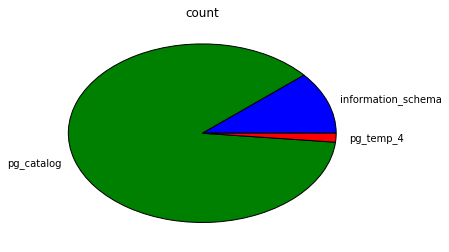

In [33]:
%matplotlib inline

r.pie()

`%sql` also makes it easy to create new tables (but `CREATE TABLE ... AS SELECT ...` would be far more efficmient)

In [34]:
%sql PERSIST df

u'Persisted df'

In [35]:
%sql SELECT * FROM df

3 rows affected.


index,schemaname,count
0,information_schema,7
1,pg_catalog,54
2,pg_temp_4,1


In [36]:
r

schemaname,count
information_schema,7
pg_catalog,54
pg_temp_4,1


You can only persist a DataFrame though...

In [37]:
%sql PERSIST r

TypeError: r is not a Pandas DataFrame or Series

In [38]:
c.execute('SELECT * FROM df')
df_psy_result = c.fetchall()
df_psy_result

[(0L, 'information_schema', 7L),
 (1L, 'pg_catalog', 54L),
 (2L, 'pg_temp_4', 1L)]

In [39]:
type(df_psy_result)

list

In [40]:
type(df_psy_result[0])

tuple

In [41]:
c.description

(Column(name='index', type_code=20, display_size=None, internal_size=8, precision=None, scale=None, null_ok=None),
 Column(name='schemaname', type_code=25, display_size=None, internal_size=-1, precision=None, scale=None, null_ok=None),
 Column(name='count', type_code=20, display_size=None, internal_size=8, precision=None, scale=None, null_ok=None))

In [42]:
import psycopg2.extras
c2 = db.cursor(cursor_factory=psycopg2.extras.DictCursor)
c2.execute('SELECT * FROM df')
c2_df_result = c2.fetchall()
c2_df_result

[[0L, 'information_schema', 7L],
 [1L, 'pg_catalog', 54L],
 [2L, 'pg_temp_4', 1L]]

In [43]:
type(c2_df_result[0])

psycopg2.extras.DictRow

In [44]:
row = c2_df_result[0]

In [45]:
row.keys()

['count', 'index', 'schemaname']

In [46]:
row

[0L, 'information_schema', 7L]

In [47]:
row[0]

0L

In [48]:
row['index']

0L

In [49]:
row['index'] is row[0]

True

In [50]:
c2.execute('UPDATE df SET index=index*10')

In [51]:
c2_df_result

[[0L, 'information_schema', 7L],
 [1L, 'pg_catalog', 54L],
 [2L, 'pg_temp_4', 1L]]

In [52]:
c2.fetchall()

ProgrammingError: no results to fetch

In [53]:
c2.execute('SELECT * FROM df')

In [54]:
c2.fetchall()

[[0L, 'information_schema', 7L],
 [10L, 'pg_catalog', 54L],
 [20L, 'pg_temp_4', 1L]]

What if that's not what I wanted to do?

In [55]:
db.autocommit

False

In [56]:
db.rollback()
c.execute('UPDATE df SET index=index+10')
c2.fetchall()

[]

Why didn't that `fetchall()` bomb like the other one?

In [57]:
c2.execute('SELECT * FROM df')
c2.fetchall()

[[10L, 'information_schema', 7L],
 [11L, 'pg_catalog', 54L],
 [12L, 'pg_temp_4', 1L]]

`%sql` can't see these updates yet though...

In [58]:
%sql SELECT * FROM df

3 rows affected.


index,schemaname,count
0,information_schema,7
1,pg_catalog,54
2,pg_temp_4,1


In [59]:
c2.commit()

AttributeError: 'DictCursor' object has no attribute 'commit'

In [60]:
c2.connection.commit()
c2.connection is db

True

In [61]:
%sql SELECT * FROM df

3 rows affected.


index,schemaname,count
10,information_schema,7
11,pg_catalog,54
12,pg_temp_4,1


`c2_df_result` is unchanged though...

In [62]:
c2_df_result

[[0L, 'information_schema', 7L],
 [1L, 'pg_catalog', 54L],
 [2L, 'pg_temp_4', 1L]]

We can easily turn tuple results into a dataframe, but the dataframe won't have any names.

In [63]:
c.execute(SQLactivity)
pd.DataFrame(c.fetchall())

,0,1,2,3,4,5,6
0,46931,decibel,decibel,psql,2016-11-12 01:08:56.806783+00:00,idle,SELECT pg_catalog.pg_backend_pid() AS backend_...
1,46976,decibel,decibel,,2016-11-12 01:25:05.126718+00:00,idle,SELECT * FROM df
2,47259,decibel,decibel,psycopg2,2016-11-12 01:25:14.888732+00:00,active,"SELECT pid,datname,usename,application_name,st..."
3,48932,decibel,decibel,,2016-11-12 01:14:43.449379+00:00,idle,COMMIT


Results from `c2` would have names associated with them, but...

In [64]:
c2.execute(SQLactivity)
pd.DataFrame([row for row in c2])

TypeError: Expected list, got DictRow

In [65]:
c2.execute(SQLactivity)
pd.DataFrame([dict(row) for row in c2])

,application_name,datname,pid,query,state,state_change,usename
0,psql,decibel,46931,SELECT pg_catalog.pg_backend_pid() AS backend_...,idle,2016-11-12 01:08:56.806783+00:00,decibel
1,,decibel,46976,SELECT * FROM df,idle,2016-11-12 01:25:05.126718+00:00,decibel
2,psycopg2,decibel,47259,"SELECT pid,datname,usename,application_name,st...",active,2016-11-12 01:25:14.888732+00:00,decibel
3,,decibel,48932,COMMIT,idle,2016-11-12 01:14:43.449379+00:00,decibel


In [66]:
new_df=pd.read_sql(SQLactivity, db)
new_df

,pid,datname,usename,application_name,state_change,state,query
0,46931,decibel,decibel,psql,2016-11-12 01:08:56.806783+00:00,idle,SELECT pg_catalog.pg_backend_pid() AS backend_...
1,46976,decibel,decibel,,2016-11-12 01:25:05.126718+00:00,idle,SELECT * FROM df
2,47259,decibel,decibel,psycopg2,2016-11-12 01:25:14.888732+00:00,active,"SELECT pid,datname,usename,application_name,st..."
3,48932,decibel,decibel,,2016-11-12 01:14:43.449379+00:00,idle,COMMIT


In [67]:
%sql SELECT pid,datname,usename,application_name,state_change,state,query FROM pg_stat_activity

4 rows affected.


pid,datname,usename,application_name,state_change,state,query
46931,decibel,decibel,psql,2016-11-12 01:08:56.806783+00:00,idle,SELECT pg_catalog.pg_backend_pid() AS backend_pid
46976,decibel,decibel,,2016-11-12 01:25:55.772292+00:00,active,"SELECT pid,datname,usename,application_name,state_change,state,query FROM pg_stat_activity"
47259,decibel,decibel,psycopg2,2016-11-12 01:25:36.294069+00:00,idle in transaction,"SELECT pid,datname,usename,application_name,state_change,state,query FROM pg_stat_activity"
48932,decibel,decibel,,2016-11-12 01:14:43.449379+00:00,idle,COMMIT


In [68]:
c2_df_result

[[0L, 'information_schema', 7L],
 [1L, 'pg_catalog', 54L],
 [2L, 'pg_temp_4', 1L]]

In [69]:
%sql SELECT * FROM df

3 rows affected.


index,schemaname,count
10,information_schema,7
11,pg_catalog,54
12,pg_temp_4,1


In [70]:
# Lets create a new table...
c2.execute('CREATE TABLE df2(s serial, index int, schemaname name, count bigint)')

# And insert a row into it
SQLdf2_insert='INSERT INTO df2 VALUES(DEFAULT, %(index)s, %(schemaname)s, %(count)s)'
c2.execute(SQLdf2_insert, c2_df_result[0])

In [71]:
%sql SELECT * FROM df2

(ProgrammingError) relation "df2" does not exist
LINE 1: SELECT * FROM df2
                      ^
 'SELECT * FROM df2' {}


In [72]:
db.commit()

In [73]:
%sql SELECT * FROM df2

1 rows affected.


s,index,schemaname,count
1,0,information_schema,7


In [74]:
c.executemany(SQLdf2_insert, c2_df_result) # Note executemany(), not just execute()
pd.read_sql('SELECT * FROM df2', db)

,s,index,schemaname,count
0,1,0,information_schema,7
1,2,0,information_schema,7
2,3,1,pg_catalog,54
3,4,2,pg_temp_4,1


In [75]:
c.execute('SELECT * FROM df2')
c.fetchall()

[(1, 0, 'information_schema', 7L),
 (2, 0, 'information_schema', 7L),
 (3, 1, 'pg_catalog', 54L),
 (4, 2, 'pg_temp_4', 1L)]

In [76]:
c3=db.cursor(cursor_factory=psycopg2.extras.NamedTupleCursor)
c3.execute('SELECT * FROM df2')
r=c3.fetchall()
r

[Record(s=1, index=0, schemaname='information_schema', count=7L),
 Record(s=2, index=0, schemaname='information_schema', count=7L),
 Record(s=3, index=1, schemaname='pg_catalog', count=54L),
 Record(s=4, index=2, schemaname='pg_temp_4', count=1L)]

In [77]:
r[0]

Record(s=1, index=0, schemaname='information_schema', count=7L)

In [78]:
r[0][0]

1

In [79]:
r[0].s

1

In [80]:
r[0][1] is r[0].index

True

In [81]:
c3.execute(SQLdf2_insert + ' RETURNING *', r[0]._asdict())
c3.fetchall()

[Record(s=5, index=0, schemaname='information_schema', count=7L)]

In [82]:
%sql SELECT * FROM df2

1 rows affected.


s,index,schemaname,count
1,0,information_schema,7


In [83]:
with db:
    c3.execute(SQLdf2_insert + ' RETURNING *', r[0]._asdict())
    r=c3.fetchall()

In [84]:
r

[Record(s=6, index=0, schemaname='information_schema', count=7L)]

In [85]:
%sql SELECT * FROM df2

6 rows affected.


s,index,schemaname,count
1,0,information_schema,7
2,0,information_schema,7
3,1,pg_catalog,54
4,2,pg_temp_4,1
5,0,information_schema,7
6,0,information_schema,7


In [86]:
c.execute('BAD SQL')

ProgrammingError: syntax error at or near "BAD"
LINE 1: BAD SQL
        ^


In [87]:
c.execute('SELECT 1').fetchall()

InternalError: current transaction is aborted, commands ignored until end of transaction block


In [88]:
db.rollback()

In [89]:
with db:
    c.executemany(SQLdf2_insert, c2_df_result)
    c.execute('BAD SQL')
    c.execute('SELECT 1')
    c.fetchall()

ProgrammingError: syntax error at or near "BAD"
LINE 1: BAD SQL
        ^


In [90]:
c.execute('SELECT 1')
c.fetchall()

[(1,)]

In [91]:
with db.cursor() as new_c:
    new_c.execute('SELECT * FROM df2')
    r=new_c.fetchall()

In [92]:
r

[(1, 0, 'information_schema', 7L),
 (2, 0, 'information_schema', 7L),
 (3, 1, 'pg_catalog', 54L),
 (4, 2, 'pg_temp_4', 1L),
 (5, 0, 'information_schema', 7L),
 (6, 0, 'information_schema', 7L)]

In [93]:
new_c

<cursor object at 0x1093cb718; closed: -1>

In [94]:
new_c.execute('SELECT 1')

InterfaceError: cursor already closed

psycopg2 supports non-standard types

In [95]:
c.execute("CREATE TYPE card AS (value text, suit text);")

In [96]:
c.execute("SELECT ('Ace', 'Spades')::card")
r=c.fetchone()[0]
r

'(Ace,Spades)'

In [97]:
type(r)

str

In [98]:
psycopg2.extras.register_composite('card', c)
c.execute("SELECT ('Ace', 'Spades')::card")
r=c.fetchone()[0]
r

card(value='Ace', suit='Spades')

In [99]:
type(r)

psycopg2.extras.card

In [100]:
%sql CREATE TYPE complex AS(r float, i float)

Done.


[]

In [101]:
c3.execute('SELECT row(.1,.2)::complex')
r=c3.fetchone()
r

Record(row='(0.1,0.2)')

In [102]:
type(r)

psycopg2.extras.Record

In [103]:
type(r.row)

str

In [104]:
z=complex(2,3)
z

(2+3j)

In [105]:
c2.execute('SELECT %s',(z,))
r=c2.fetchone()
r

ProgrammingError: can't adapt type 'complex'

In [106]:
import psycopg2.extensions as exten

In [107]:
def adapt_complex(c):
    return exten.AsIs("(%s,%s)" % (c.real, c.imag))

In [108]:
exten.register_adapter(complex,adapt_complex)

In [109]:
c.execute('CREATE TABLE c AS SELECT %s::complex AS c', (z,))

In [110]:
c.execute('INSERT INTO c VALUES(%s),(%s)',(z * 2, z.conjugate()))
c2.execute('SELECT * FROM c')
r=c2.fetchall()
db.commit()
r

[['(2,3)'], ['(4,6)'], ['(2,-3)']]

In [111]:
type(r[0][0])

str

In [112]:
%sql SELECT * FROM c

3 rows affected.


c
"(2,3)"
"(4,6)"
"(2,-3)"


In [113]:
%sql SELECT (c).* FROM c

3 rows affected.


r,i
2.0,3.0
4.0,6.0
2.0,-3.0


In [116]:
import re
def cast_complex(value, cursor):
    if value is None:
        return None
    
    # Match a value that looks like (foo,bar)
    m = re.match(r"\(([^)]+),([^)]+)\)", value)
    if m:
        return complex(float(m.group(1)),float(m.group(2)))
    else:
        raise InterfaceError("bad representation for type complex: %r" % value)

In [117]:
c2.description[0]

Column(name='c', type_code=3150012, display_size=None, internal_size=-1, precision=None, scale=None, null_ok=None)

In [118]:
c2.description[0].type_code

3150012

In [119]:
complex_caster = exten.new_type((c2.description[0].type_code,), 'complex', cast_complex)

In [120]:
complex_caster

<psycopg2._psycopg.type 'complex' at 0x1097d1578>

In [121]:
exten.register_type(complex_caster)

In [122]:
c2.execute('SELECT * FROM c')
r=c2.fetchall()
r

[[(2+3j)], [(4+6j)], [(2-3j)]]

In [123]:
type(r[0][0])

complex

In [124]:
%sql SELECT * FROM c

3 rows affected.


c
(2+3j)
(4+6j)
(2-3j)


## Questions?
#### Jim.Nasby@BlueTreble.com

#### This notebook can be downloaded from https://github.com/AustinPUG/PGDay2016/blob/master/Python%2BPostgres.ipynb (search for PGDay2016 on Github)